# Potato Disease Classifaction

# Import all the dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 2 0 0 1 1 0 1 0 0 0 1 0 0 1 2 0 1 0 2 1 1 1 0 0 0 0 1 1 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())  ### converting into numpy

[[[165. 144. 151.]
  [170. 149. 156.]
  [150. 129. 136.]
  ...
  [183. 167. 177.]
  [182. 166. 176.]
  [179. 163. 173.]]

 [[157. 136. 143.]
  [164. 143. 150.]
  [128. 107. 114.]
  ...
  [188. 172. 182.]
  [188. 172. 182.]
  [185. 169. 179.]]

 [[151. 130. 137.]
  [154. 133. 140.]
  [149. 128. 135.]
  ...
  [187. 171. 181.]
  [188. 172. 182.]
  [185. 169. 179.]]

 ...

 [[211. 198. 205.]
  [200. 187. 194.]
  [190. 177. 184.]
  ...
  [192. 180. 190.]
  [199. 187. 197.]
  [204. 192. 202.]]

 [[195. 182. 189.]
  [206. 193. 200.]
  [190. 177. 184.]
  ...
  [196. 184. 194.]
  [199. 187. 197.]
  [201. 189. 199.]]

 [[206. 193. 200.]
  [183. 170. 177.]
  [212. 199. 206.]
  ...
  [198. 186. 196.]
  [197. 185. 195.]
  [197. 185. 195.]]]


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape) 

(256, 256, 3)


# Visualize some of the images from our dataset

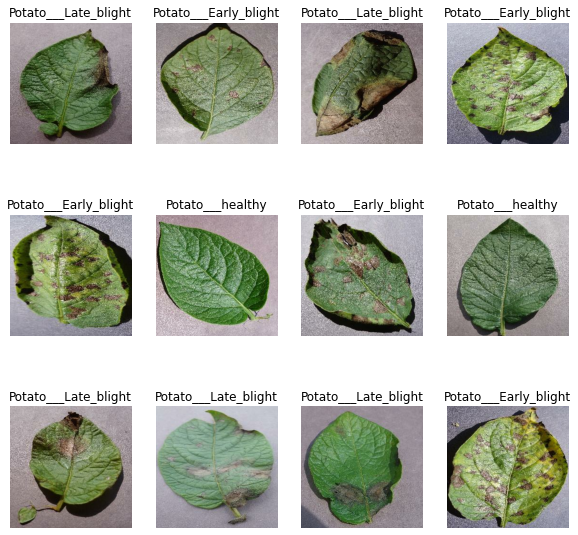

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

### Dataset is splited into 3 subsets, namely:

1)Training: Dataset to be used while training.

2)Validation: Dataset to be tested against while training.

3)Test: Dataset to be tested against after we trained a model.

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)             #### take 1st 54 batches 

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 148s 133ms/step - loss: 0.9170 - accuracy: 0.4502 - val_loss: 0.8628 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 3s 56ms/step - loss: 0.7703 - accuracy: 0.6458 - val_loss: 0.5536 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 3s 55ms/step - loss: 0.4793 - accuracy: 0.8027 - val_loss: 0.3597 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 3s 55ms/step - loss: 0.3166 - accuracy: 0.8657 - val_loss: 0.3276 - val_accuracy: 0.8542
Epoch 5/50
54/54 [==============================] - 3s 56ms/step - loss: 0.2721 - accuracy: 0.8895 - val_loss: 0.2149 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 3s 55ms/step - loss: 0.1847 - accuracy: 0.9317 - val_loss: 0.2398 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 3s 55ms/step - loss: 0.1710 - accuracy: 0.9323 - val_loss: 0.1807 - val_accuracy: 0.9271
Epoch 8/50

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 27ms/step - loss: 0.0570 - accuracy: 0.9883


You can see above that we get 98.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [28]:
scores

[0.05698594078421593, 0.98828125]

# Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

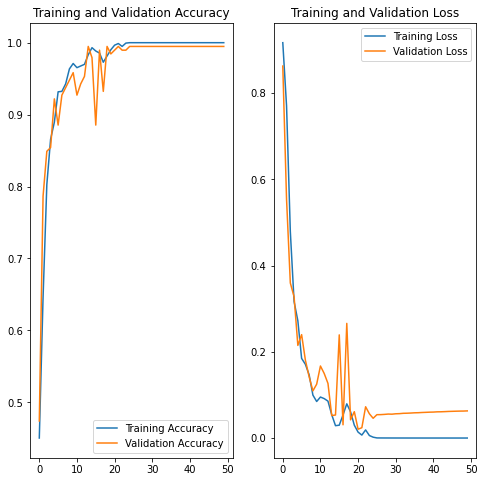

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

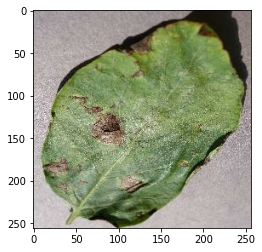

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[0].numpy().astype('uint8')) ############# 1st image 
 

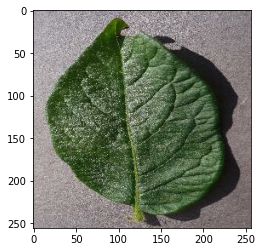

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[1].numpy().astype('uint8')) ############# 2nd image 

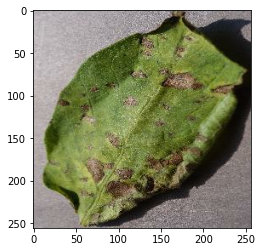

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[2].numpy().astype('uint8')) ############# 3rd image 

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


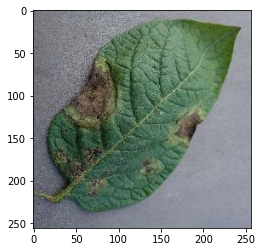

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

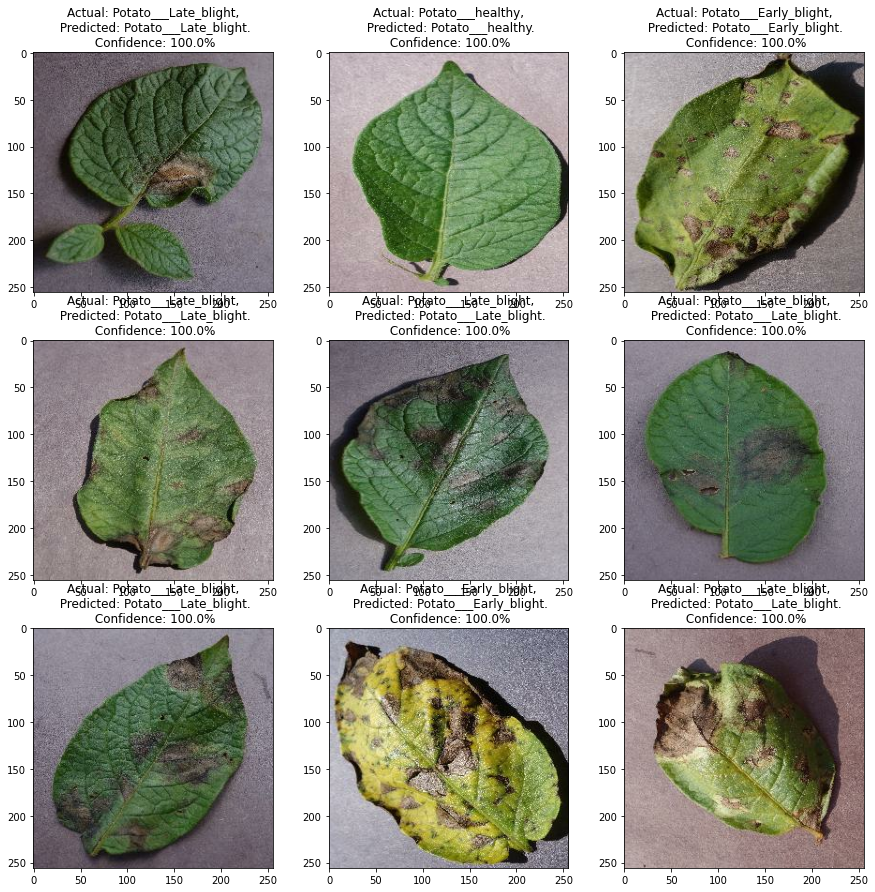

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")